## BÚSQUEDA AUTOMÁTICA DE HIPERPARÁMETROS
#### (WIP)



In [ ]:
# ───── Setup para utilizar MPS, CUDA o CPU de acuerdo a recursos disponibles) ─────
import os
import tensorflow as tf

# 1. Enable best available GPU (MPS or CUDA)
if tf.config.list_physical_devices('GPU'):
    # Already sees GPU → let TF pick (MPS on Mac, CUDA on Linux/Windows)
    pass
else:
    # Force MPS on Apple Silicon if not auto-detected (rare)
    if os.uname().sysname == "Darwin" and "arm64" in os.uname().machine:
        os.environ["TF_METAL"] = "1"

# 2. Nice defaults for any GPU
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

# 3. Seteo de mixed precision (más rapido con GPUs)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# 4. Verificar
print("GPUs detectadas      :", tf.config.list_physical_devices('GPU'))
print("Mixed precision    :", mixed_precision.global_policy())

# ───── In your build_transformer function → ONLY change the last layer ─────
# Change this line:
# outputs = layers.Dense(1)(x)
# → to:
outputs = layers.Dense(1, dtype='float32')(x)   # Critical with mixed_float16!

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [39]:
# Temperaturas diurnas (diarias)
df_d_diaria = pd.read_csv("csv/ts_d_diario_imputado.csv", parse_dates=["fecha"],
    dtype={"pino": "float64",
           "estepa": "float64",
           "mes": "int64",
           "delta": "float64"
          })

df_d_diaria.head(10)

,fecha,estepa,pino,mes,delta
0,2020-01-01,35.433453,33.666374,1,1.767079
1,2020-01-02,36.195872,31.342840,1,4.853032
2,2020-01-03,35.245773,31.284172,1,3.961601
3,2020-01-04,38.821326,31.450303,1,7.371023
4,2020-01-05,25.626907,17.944593,1,7.682314
5,2020-01-06,24.419361,19.761171,1,4.658190
6,2020-01-07,25.590980,19.523039,1,6.067942
7,2020-01-08,23.595392,18.317425,1,5.277967
8,2020-01-09,24.220856,18.704153,1,5.516703
9,2020-01-10,27.450967,22.472114,1,4.978853


## 4. Modelos predictivos

In [42]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

### Preparación de datos para entrenamiento

In [44]:
df_serie = df_d_diaria[['fecha','delta']]
df_serie = df_serie.set_index('fecha')
df_serie.index = pd.to_datetime(df_serie.index)
df_serie.head()

,delta
fecha,
2020-01-01,1.767079
2020-01-02,4.853032
2020-01-03,3.961601
2020-01-04,7.371023
2020-01-05,7.682314


In [45]:
train_size = int(len(df_serie) * 0.8)  # 80% entrenamiento, 20% test
train_size

1461

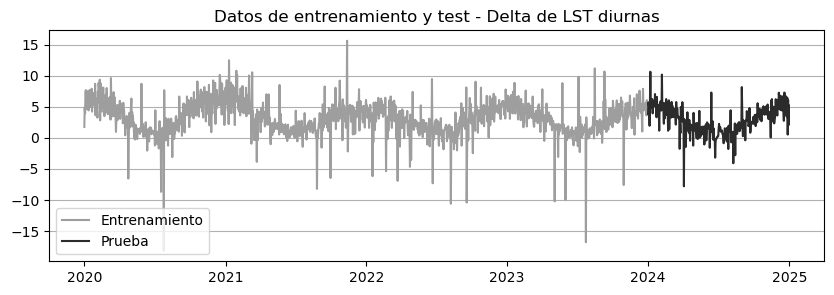

In [46]:
train = df_serie['delta'].iloc[:train_size]
test = df_serie['delta'].iloc[train_size:]

plt.figure(figsize=(10, 3))
plt.plot(train, label='Entrenamiento', color=colores['train'])
plt.plot(test, label='Prueba', color=colores['test'])
#plt.legend()
plt.legend(loc='lower left')

plt.grid(axis='y')
plt.title('Datos de entrenamiento y test - Delta de LST diurnas')
plt.show()

### PREPARA LOS DATOS

In [57]:
# Incluimos (opcionalmente) características estacionales (seno y coseno)
df_lstm = df_serie.copy()
use_seasonal_features = False  # False: usar solo el dato delta temperatura
if use_seasonal_features:
    df_lstm['semana_del_año'] = df_lstm.index.isocalendar().week
    df_lstm['sin_semana'] = np.sin(2 * np.pi * df_lstm['semana_del_año'] / 52)
    df_lstm['cos_semana'] = np.cos(2 * np.pi * df_lstm['semana_del_año'] / 52)
    data_to_scale = df_lstm[['delta', 'sin_semana', 'cos_semana']].values
else:
    data_to_scale = df_lstm[['delta']].values

In [58]:
data_min = data_to_scale.min()
data_max = data_to_scale.max()
print(f"Datos sin escalar: [{data_min:.4f}, {data_max:.4f}]")

Datos sin escalar: [-18.1780, 15.6332]


In [59]:
# Escalar los datos
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data_to_scale)
print(f"Datos escalados: [{data_scaled.min():.4f}, {data_scaled.max():.4f}]")

Datos escalados: [-1.0000, 1.0000]


In [60]:
# Crear secuencias
def create_sequences(data, seq_length, target_idx=0):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, target_idx])
    return np.array(X), np.array(y)

# Crear secuencias para entrenamiento y prueba
seq_length = 182  # 1/2 año de datos
X, y = create_sequences(data_scaled, seq_length, target_idx=0)
X_train, y_train = X[:train_size - seq_length], y[:train_size - seq_length]
X_test, y_test = X[train_size - seq_length:], y[train_size - seq_length:]


### b) Transformer con búsqueda de hiperparámetros

In [ ]:
class PositionalEncoding(layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        self.seq_len = seq_len
        self.d_model = d_model
        
        # Crea matriz de positional encoding (sinusoide fija)
        pe = np.zeros((seq_len, d_model))
        position = np.arange(0, seq_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe[np.newaxis, ...]  # (1, seq_len, d_model)
        self.pe = tf.constant(pe, dtype=tf.float32)
    
    def call(self, inputs):
        return inputs + self.pe[:, :tf.shape(inputs)[1], :]


def build_transformer(d_model=64, n_heads=4, n_layers=2, ff_dim=128, dropout=0.1, final_dropout=0.2, lr=1e-4):
    seq_length = 182
    n_features = X_train.shape[2]  # 1 o 3

    inputs = Input(shape=(seq_length, n_features))
    
    # 1. Proyección lineal a d_model
    x = layers.Dense(d_model)(inputs)
    
    # 2. POSITIONAL ENCODING
    x = PositionalEncoding(seq_length, d_model)(x)
    
    # 3. Bloques Transformer
    for _ in range(n_layers):
        # Multi-Head Self Attention
        attn_output = layers.MultiHeadAttention(
            num_heads=n_heads, key_dim=d_model//n_heads, dropout=dropout
        )(x, x)
        attn_output = layers.Dropout(dropout)(attn_output)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        # Feed Forward
        ff = layers.Dense(ff_dim, activation='relu')(x1)
        ff = layers.Dense(d_model)(ff)
        ff = layers.Dropout(dropout)(ff)
        x = layers.LayerNormalization(epsilon=1e-6)(x1 + ff)
    
    # 4. Salida
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(final_dropout)(x)
    # outputs = layers.Dense(1)(x)
    outputs = layers.Dense(1, dtype='float32')(x)   # Critical with mixed_float16!
    
    model = Model(inputs, outputs)
    
    # Compilación
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model


#### Optimización de hiperparámetros con Optuna

In [ ]:
import optuna
from optuna import Trial

In [ ]:

def objective(trial: Trial):
    # Suggest hyperparameters
    d_model = trial.suggest_categorical("d_model", [48, 64, 80, 96, 128])
    n_heads = trial.suggest_categorical("n_heads", [4, 8])
    n_layers = trial.suggest_int("n_layers", 1, 3)
    ff_dim = trial.suggest_int("ff_dim", 96, 256, step=32)
    dropout = trial.suggest_float("dropout", 0.05, 0.15, step=0.05)
    final_dropout = trial.suggest_float("final_dropout", 0.2, 0.4, step=0.1)
    lr = trial.suggest_float("lr", 1e-4, 2e-3, log=True)
    
    # Build and train model
    model = build_transformer(d_model, n_heads, n_layers, ff_dim, dropout, final_dropout, lr)
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=300,
        batch_size=32,
        callbacks=[EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)],
        verbose=0  # Silent for speed
    )
    
    # Return best val_mae
    return min(history.history['val_mae'])

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)  # Adjust trials as needed

# Results
print("Best params:", study.best_params)
print("Best val_mae:", study.best_value)

In [66]:
# BÚSQUEDA DE HIPERPARÁMETROS (MANUAL)

from itertools import product

configs_to_try = [
    {"name": "A",  "d_model": 96, "n_heads": 8, "n_layers": 2, "ff_dim": 192, "dropout": 0.10, "final_dropout": 0.3, "lr": 0.0010},
    {"name": "B",  "d_model": 64, "n_heads": 4, "n_layers": 2, "ff_dim": 128, "dropout": 0.10, "final_dropout": 0.2, "lr": 0.0012},
    {"name": "C", "d_model": 128, "n_heads": 8, "n_layers": 3, "ff_dim": 256, "dropout": 0.15, "final_dropout": 0.4, "lr": 0.0008},
    {"name": "D",  "d_model": 48, "n_heads": 4, "n_layers": 1, "ff_dim": 96,  "dropout": 0.05, "final_dropout": 0.2, "lr": 0.0020},
    {"name": "E",  "d_model": 80, "n_heads": 8, "n_layers": 2, "ff_dim": 160, "dropout": 0.10, "final_dropout": 0.3, "lr": 0.0012},
]

results = []

for cfg in configs_to_try:
    print(f"\nEntrenando: {cfg['name']} ...")
    
    model = build_transformer(
        d_model=cfg["d_model"],
        n_heads=cfg["n_heads"],
        n_layers=cfg["n_layers"],
        ff_dim=cfg["ff_dim"],
        dropout=cfg["dropout"],
        final_dropout=cfg["final_dropout"],
        lr=cfg["lr"]
    )
    
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=300,
        batch_size=32,
        callbacks=[EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)],
        verbose=1
    )
    
    val_mae = min(history.history['val_mae'])
    print(f"{cfg['name']} → Mejor val_mae: {val_mae:.4f}")
    
    results.append({
        "config": cfg["name"],
        "val_mae": val_mae,
        "epochs": len(history.history['val_loss']),
        **cfg
    })

# RESULTADOS FINALES
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("val_mae")
print("\nRANKING FINAL:")
print(df_results[["config", "val_mae", "d_model", "n_layers", "epochs"]].to_string(index=False))

# El ganador
best_config = df_results.iloc[0].to_dict()
print(f"\nGANADOR: {best_config['config']} con MAE = {best_config['val_mae']:.4f} °C")


Entrenando: B ...
Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 335ms/step - loss: 1.1792 - mae: 0.8458 - val_loss: 0.0269 - val_mae: 0.1116
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 335ms/step - loss: 0.0898 - mae: 0.2366 - val_loss: 0.0321 - val_mae: 0.1278
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 316ms/step - loss: 0.0515 - mae: 0.1745 - val_loss: 0.0350 - val_mae: 0.1361
B → Mejor val_mae: 0.1116

Entrenando: C ...
Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 823ms/step - loss: 2.8438 - mae: 1.3251 - val_loss: 0.1903 - val_mae: 0.4178
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 753ms/step - loss: 0.3481 - mae: 0.4589 - val_loss: 0.0384 - val_mae: 0.1452
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 798ms/step - loss: 0.1223 - mae: 0.2800 - val_loss: 0.0278 - val_mae: 0.1143
C → Mejor val_mae: 0.1143

Entrenando: minimalista ...
Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - loss: 0.2819 - mae: 0.4172 - val_loss: 0.0313 - val_mae: 0.1206
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - los